<a href="https://colab.research.google.com/github/Sharan1102/Time-Series/blob/main/Final__Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from datetime import date
import time
import datetime as dt

import random
import math

from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
#!pip install pmdarima
#from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
from fastprogress import progress_bar

In [12]:
tab = pd.read_excel('/content/Final_Project.xlsx')

In [13]:
tab

,DATE,USD
0,2024-08-13,83.943500
1,2024-08-12,83.927120
2,2024-08-09,83.968019
3,2024-08-08,83.925220
4,2024-08-07,83.930000
...,...,...
6414,2000-01-07,43.485000
6415,2000-01-06,43.490000
6416,2000-01-05,43.490000
6417,2000-01-04,43.480000


In [14]:
print("Number of records:", len(tab))
print(f"Number of days between {date(2006, 1, 1)} and {date(2023, 8, 31)}: {(date(2023, 8, 31) - date(2006, 1, 1)).days}")
print(f'Percentage Data available: {round(100*len(tab)/((date(2023, 8, 31) - date(2006, 1, 1)).days), 2)}')

Number of records: 6419
Number of days between 2006-01-01 and 2023-08-31: 6451
Percentage Data available: 99.5


In [15]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    6419 non-null   datetime64[ns]
 1   USD     6419 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 100.4 KB


In [16]:
tab.sort_values('DATE', inplace = True)

In [17]:
tab['DATE'] = pd.to_datetime(tab['DATE'])
tab = tab.set_index('DATE')
#tab.head()

In [18]:
empty_cols = [col for col in tab.columns if 100*tab[col].isnull().sum()/len(tab) > 8]
print(empty_cols)
print(100*tab[empty_cols].isnull().sum()/len(tab))

[]
Series([], dtype: float64)


In [20]:
df = tab.copy()
df

,USD
DATE,
2000-01-03,43.435000
2000-01-04,43.480000
2000-01-05,43.490000
2000-01-06,43.490000
2000-01-07,43.485000
...,...
2024-08-07,83.930000
2024-08-08,83.925220
2024-08-09,83.968019


In [21]:
df = df.interpolate(method = 'bfill')
df.isnull().sum()

,0
USD,0


In [22]:
df.head()

,USD
DATE,
2000-01-03,43.435
2000-01-04,43.480
2000-01-05,43.490
2000-01-06,43.490
2000-01-07,43.485


<Axes: xlabel='DATE'>

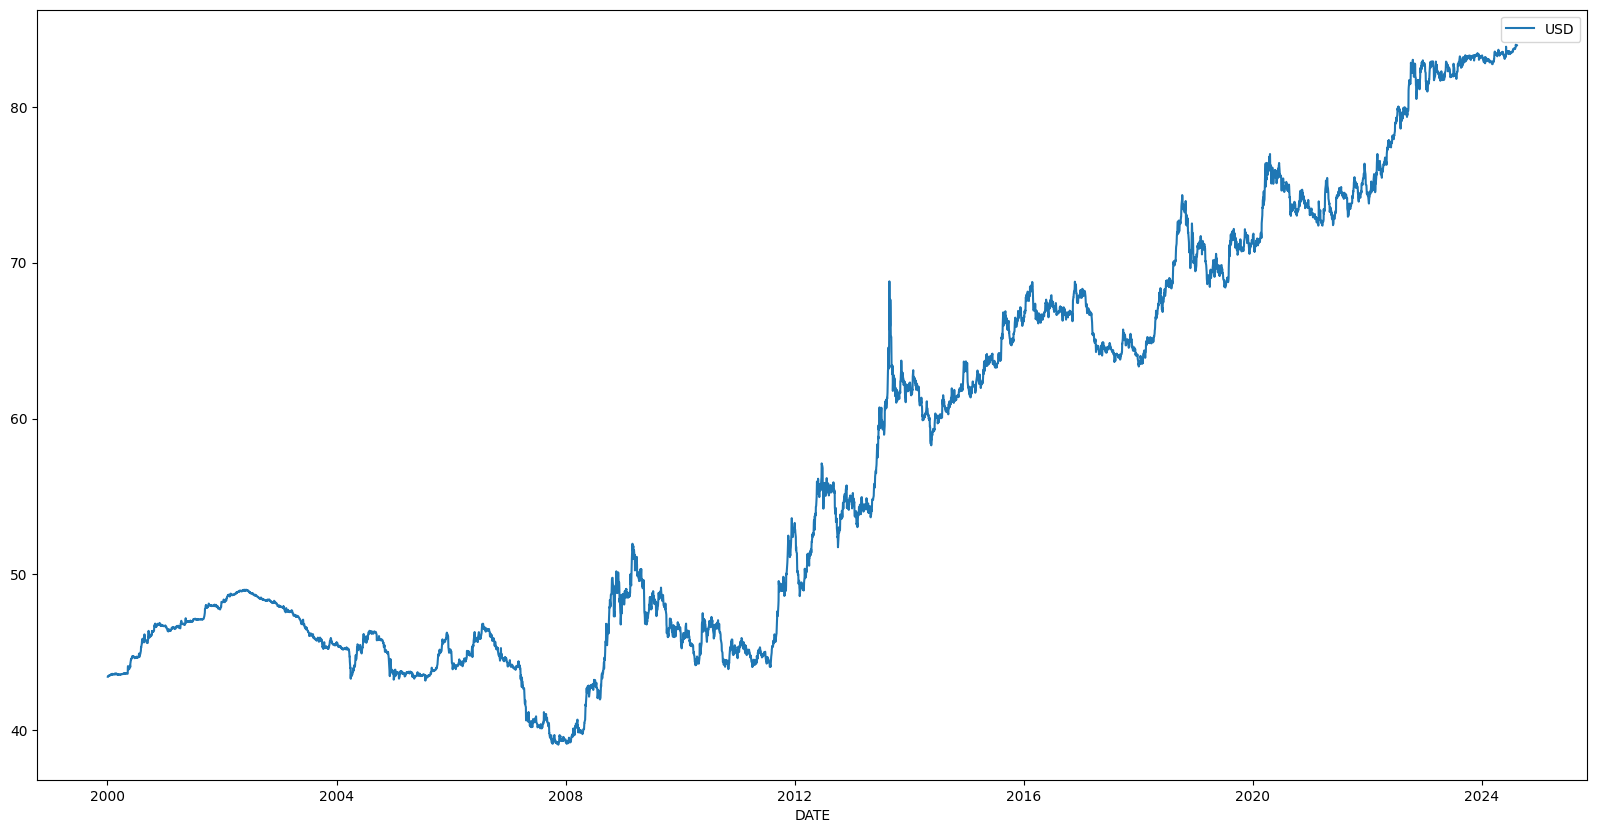

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.lineplot(df[:])

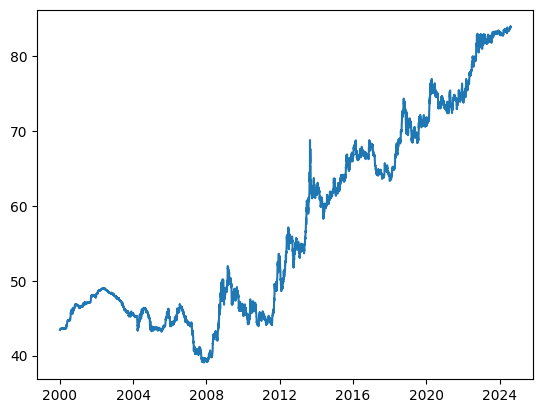

In [24]:
name = 'USD'
plt.plot(df[name])
plt.show()

In [25]:
data = pd.DataFrame(df[name])
data.head()

,USD
DATE,
2000-01-03,43.435
2000-01-04,43.480
2000-01-05,43.490
2000-01-06,43.490
2000-01-07,43.485


In [26]:
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(data[name])

ADF Statistic: 0.359510
p-value: 0.979916
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


ADF Statistic: -16.146811
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


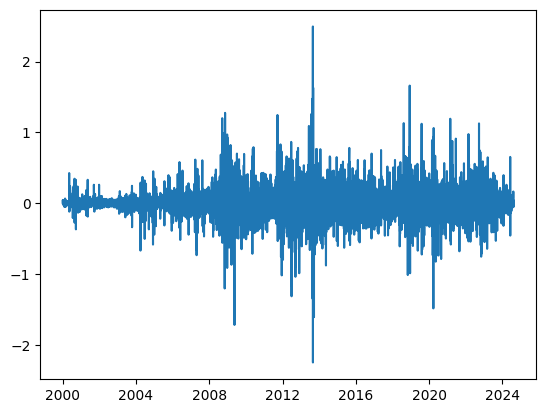

In [27]:
data['diff'] = data[name].diff().fillna(0)
check_stationarity(data['diff'])
plt.plot(data['diff'])
plt.show()

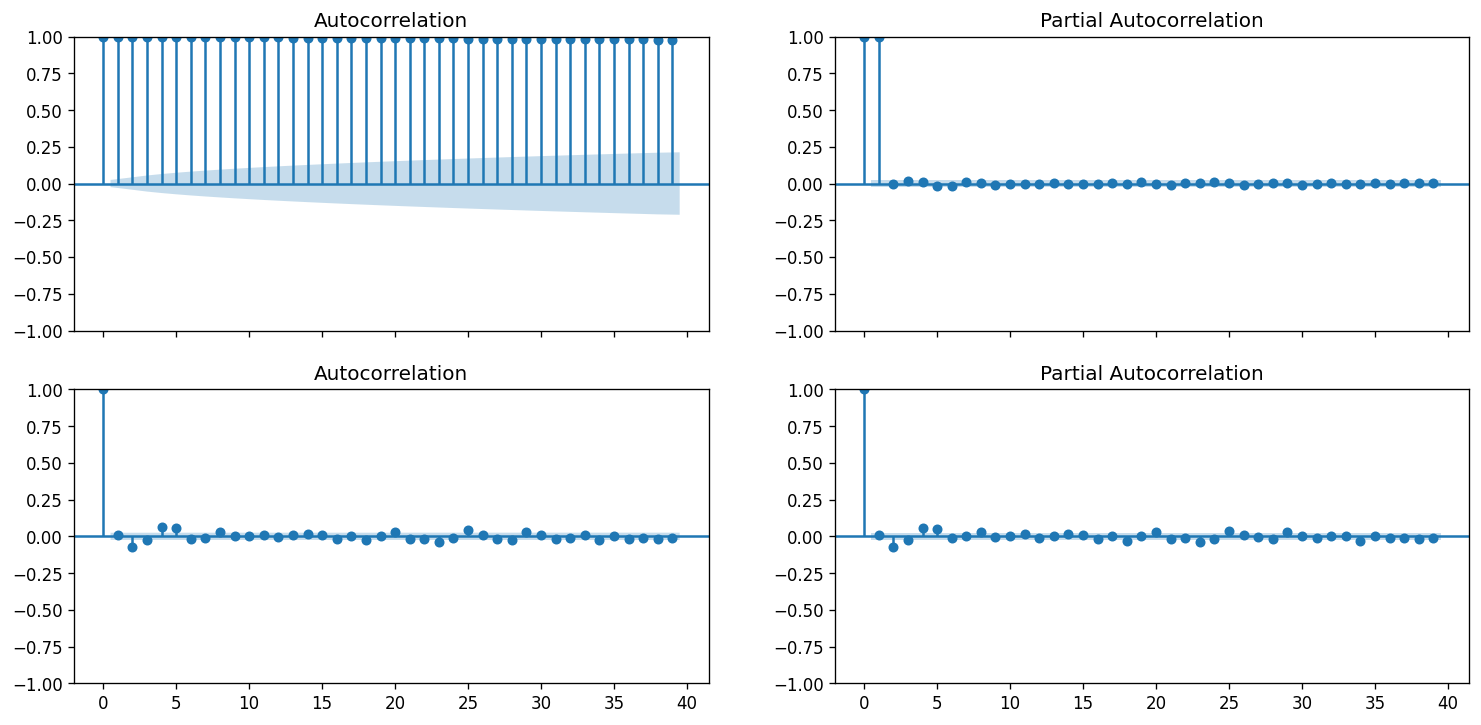

In [28]:
plt.rcParams.update({'figure.figsize':(15,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2, sharex=True)
plot_acf(data[name], ax=axes[0, 0])
plot_pacf(data[name], ax = axes[0, 1])

plot_acf(data['diff'], ax=axes[1, 0])
plot_pacf(data['diff'], ax=axes[1, 1])
plt.show()

In [29]:
print('Stationary after differencing - d = 1')
print('Spike in pacf AR - p = 2')
print('Spike in acf MA - q = 2')

Stationary after differencing - d = 1
Spike in pacf AR - p = 2
Spike in acf MA - q = 2


In [30]:
#auto_arima(data[name], seasonal=False, max_p=4, max_d=3,max_q=4, max_P=4, max_D=4,max_Q=4).summary()

In [31]:
model = ARIMA(data[name], order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    USD   No. Observations:                 6419
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 513.609
Date:                Mon, 16 Sep 2024   AIC                          -1017.218
Time:                        17:52:47   BIC                           -983.384
Sample:                             0   HQIC                         -1005.508
                               - 6419                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2652      0.042      6.349      0.000       0.183       0.347
ar.L2         -0.6345      0.049    -13.068      0.000      -0.730      -0.539
ma.L1         -0.2586      0.045     -5.809      0.0

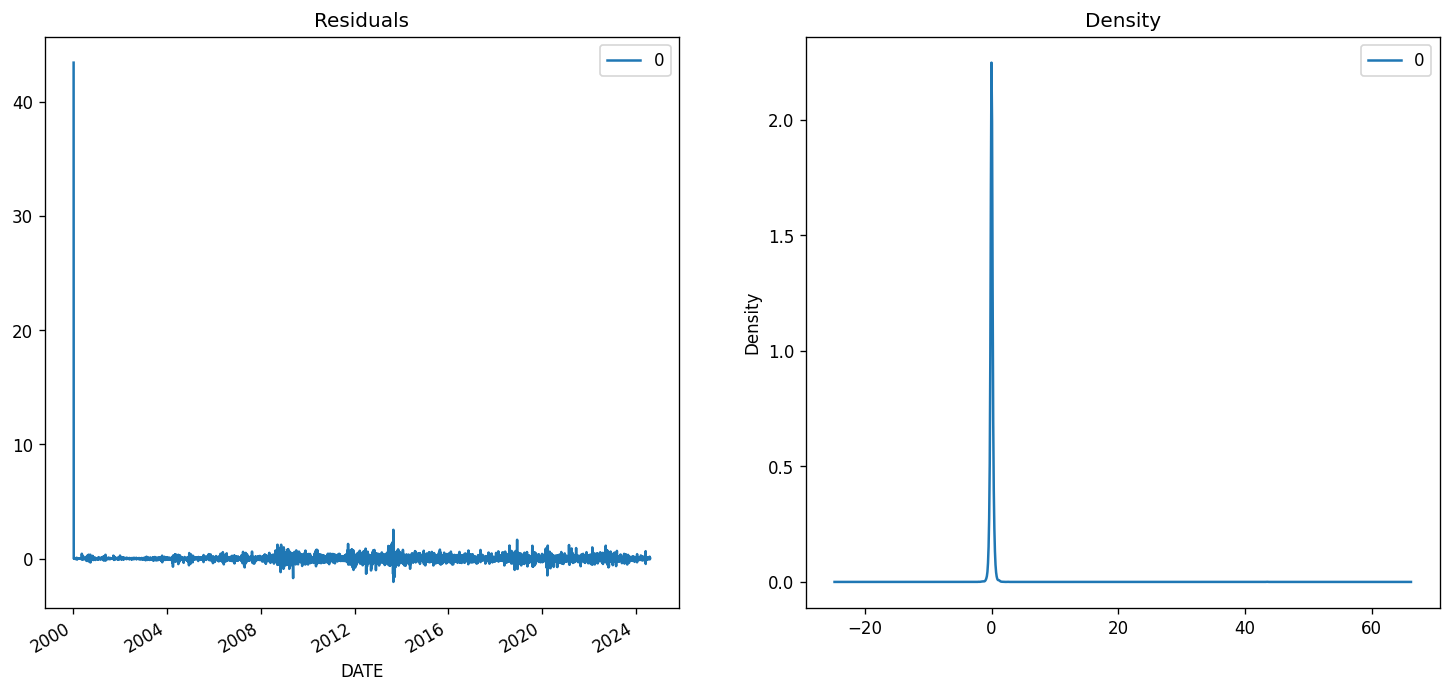

In [33]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

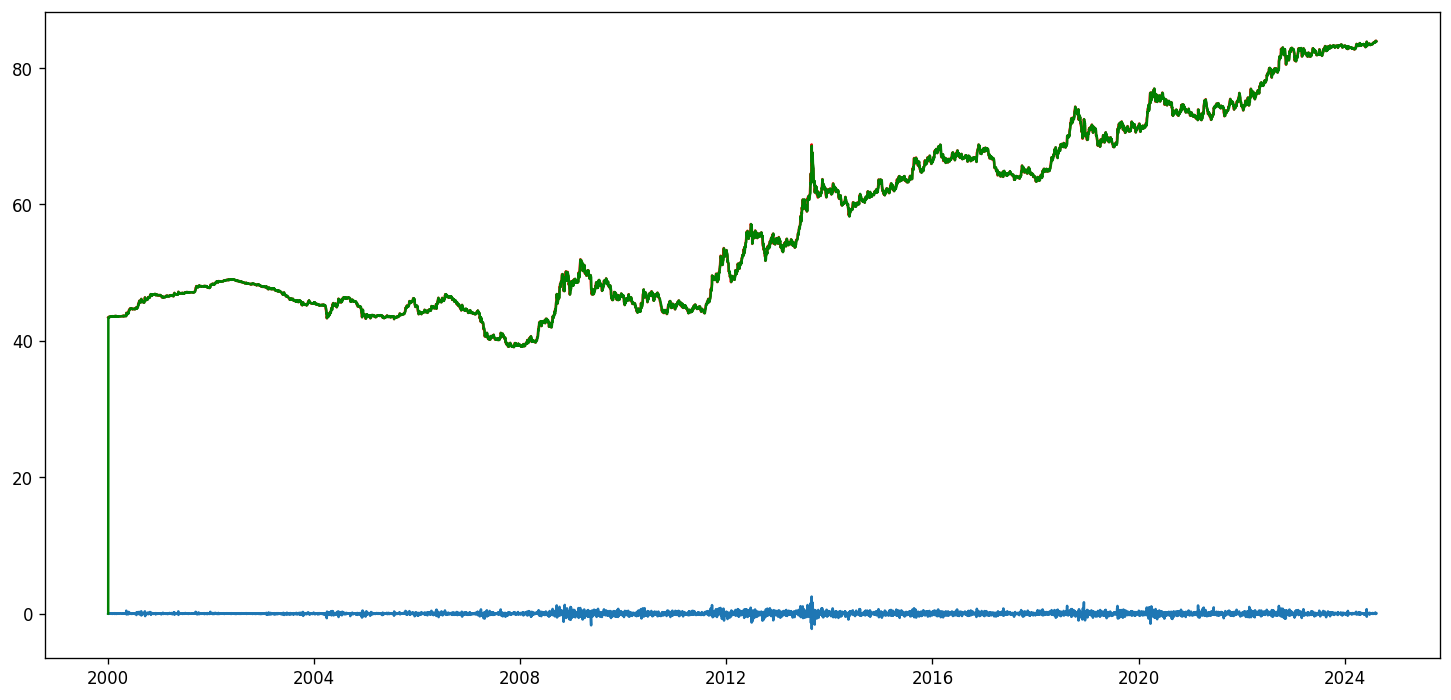

In [34]:
plt.plot(data['diff'])
plt.plot(data[name], color = 'red')
plt.plot(model_fit.fittedvalues, color = 'green')
plt.show()

In [35]:
model_fit.fittedvalues

,0
DATE,
2000-01-03,0.000000
2000-01-04,43.435000
2000-01-05,43.480351
2000-01-06,43.486466
2000-01-07,43.488068
...,...
2024-08-07,83.980892
2024-08-08,83.915875
2024-08-09,83.929211


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


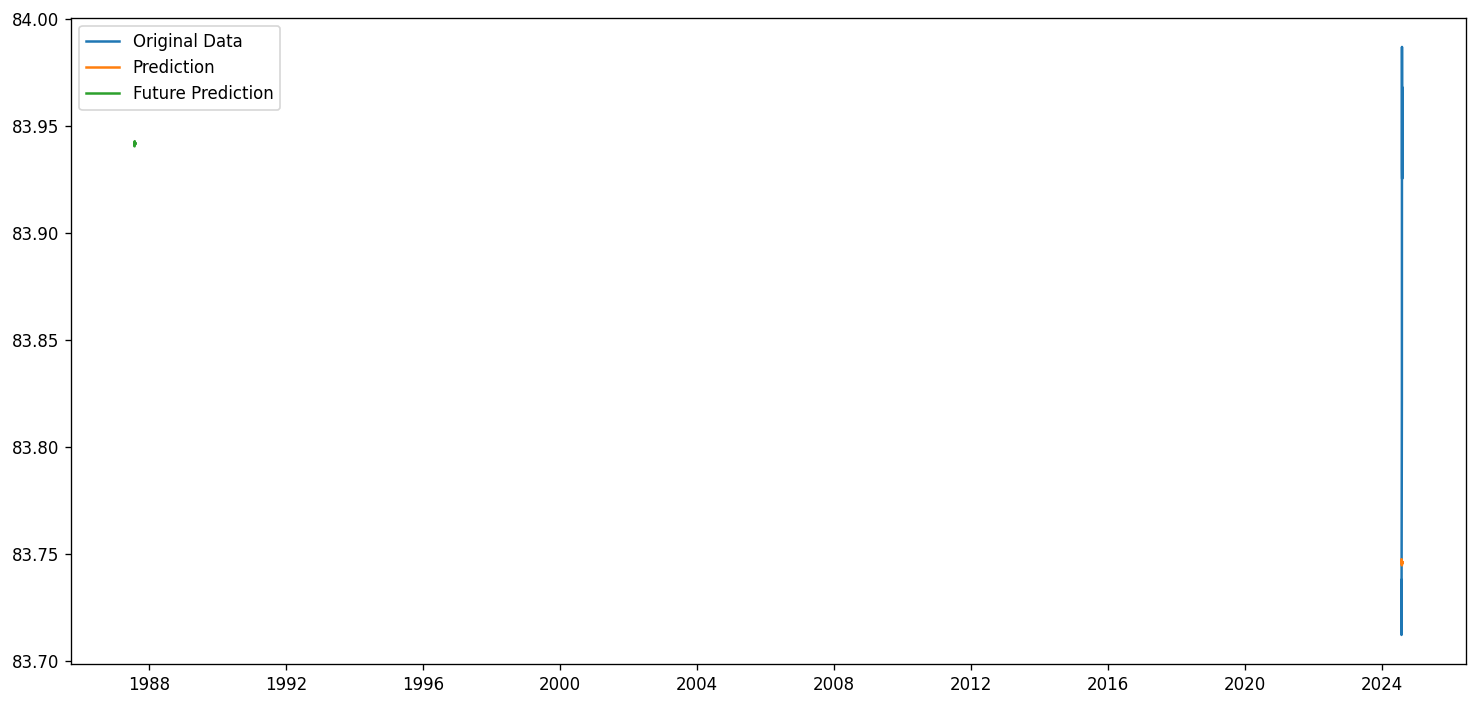

In [36]:
aug = model_fit.predict(start = len(data) - 10, end = len(data) - 1, dynamic=True)
pred_aug = model_fit.predict(start = len(data), end = len(data) + 10, dynamic=True)
plt.plot(data[name][len(data) - 10:], label = 'Original Data')
plt.plot(aug, label = 'Prediction')
plt.plot(pred_aug, label = 'Future Prediction')
plt.legend()
plt.show()

In [37]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

In [39]:
size = int(len(data)*0.95) #0.67
train, test = data[name][0:size], data[name][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in progress_bar(range(len(test))):

    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    if t%50 == 0:
        print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 



predicted = 82.880102, expected = 82.845000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 82.234365, expected = 82.245000
predicted = 83.127152, expected = 83.254000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 83.020057, expected = 83.144000
predicted = 82.878197, expected = 82.887839
predicted = 83.404195, expected = 83.407699
predicted = 83.508547, expected = 83.579581


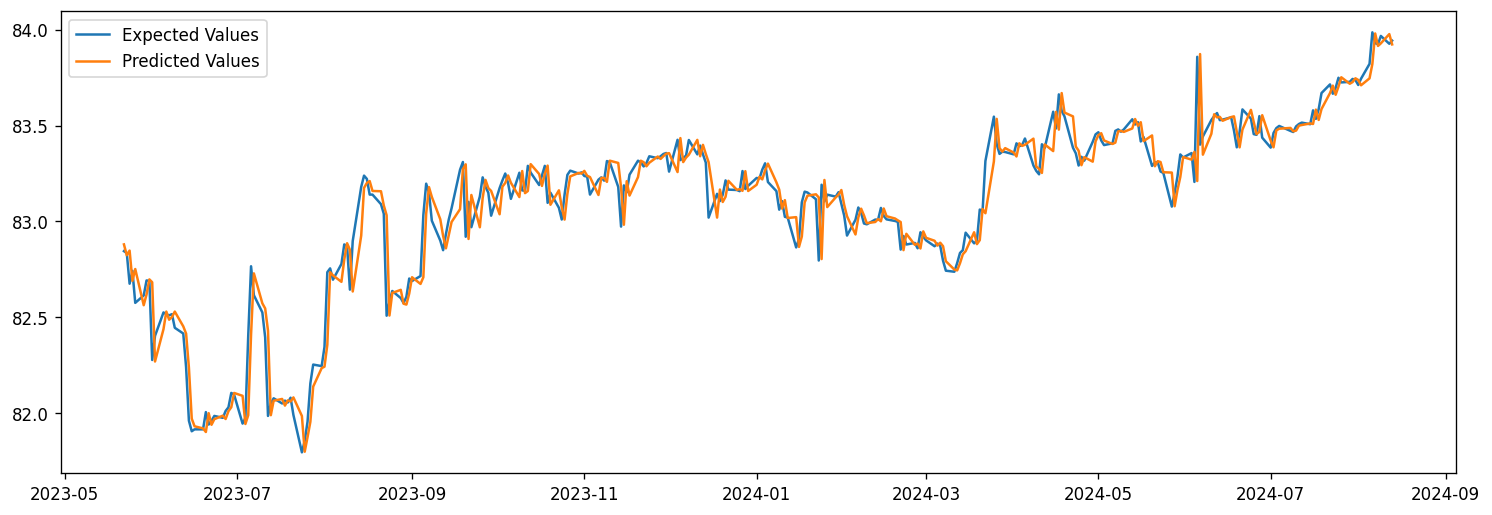

In [40]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data[name][size:len(data)],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [42]:
from pandas.tseries.offsets import DateOffset

future_dates = [data.index[-1] + DateOffset(days = x) for x in range(0,15)]

df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.tail(20)

,USD,diff,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-08-06,83.986821,0.164522,NaN,NaN
2024-08-07,83.930000,-0.056821,NaN,NaN
2024-08-08,83.925220,-0.004780,NaN,NaN
2024-08-09,83.968019,0.042799,NaN,NaN
2024-08-12,83.927120,-0.040899,NaN,NaN
2024-08-13,83.943500,0.016380,NaN,NaN
2024-08-14,NaN,NaN,NaN,NaN
2024-08-15,NaN,NaN,NaN,NaN
2024-08-16,NaN,NaN,NaN,NaN
2024-08-17,NaN,NaN,NaN,NaN


In [43]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in progress_bar(range(len(df1))):

    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    ARIMA_history_f.append(output)
    f1.append(output)

for i in range(len(f1)):
    forecast.iloc[len(data) + i,2] = f1[i]
forecast.tail(20)

,USD,diff,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-08-06,83.986821,0.164522,NaN,NaN
2024-08-07,83.930000,-0.056821,NaN,NaN
2024-08-08,83.925220,-0.004780,NaN,NaN
2024-08-09,83.968019,0.042799,NaN,NaN
2024-08-12,83.927120,-0.040899,NaN,NaN
2024-08-13,83.943500,0.016380,NaN,NaN
2024-08-14,NaN,NaN,82.880102,NaN
2024-08-15,NaN,NaN,82.859065,NaN
2024-08-16,NaN,NaN,82.869243,NaN
2024-08-17,NaN,NaN,82.885285,NaN


<Axes: >

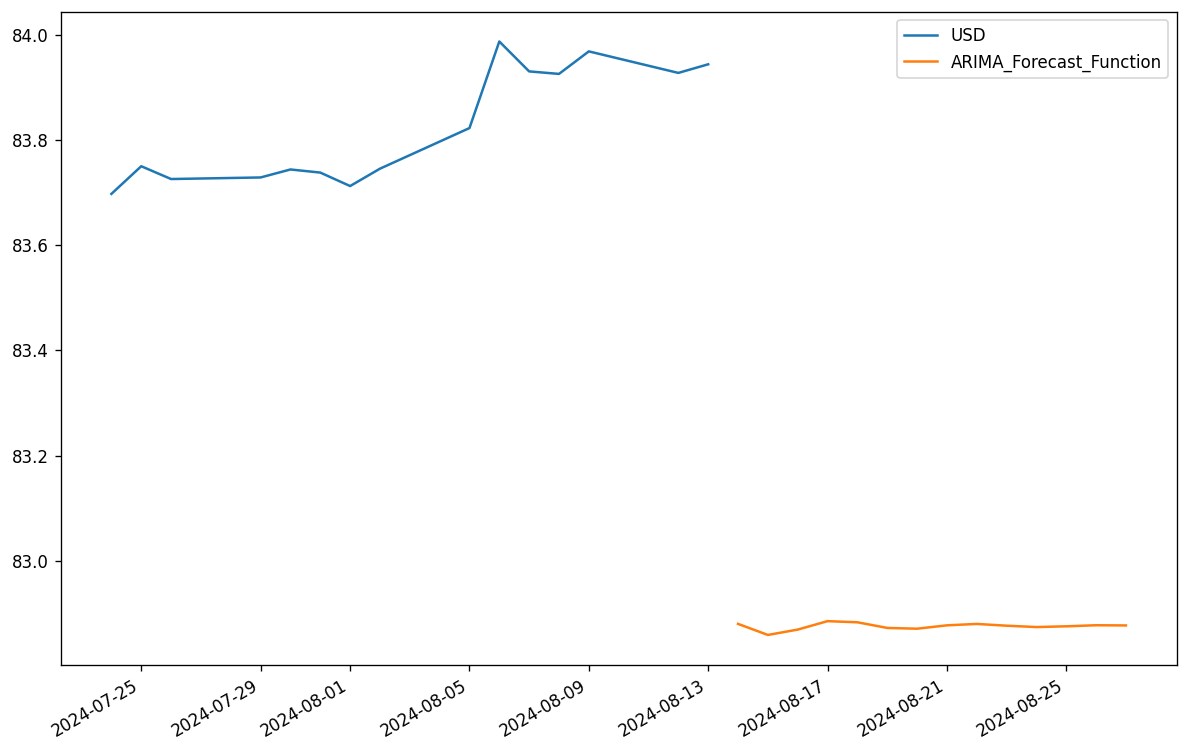

In [44]:
forecast[[name,'ARIMA_Forecast_Function']][len(data) - 15:].plot(figsize = (12,8))

In [45]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in progress_bar(range(len(df1))):

    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()

    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]

    ARIMA_history_p.append(output)
    f2.append(output)

for i in range(len(f2)):
    forecast.iloc[len(data) + i,3] = f2[i]
forecast.tail(20)

,USD,diff,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-08-06,83.986821,0.164522,NaN,NaN
2024-08-07,83.930000,-0.056821,NaN,NaN
2024-08-08,83.925220,-0.004780,NaN,NaN
2024-08-09,83.968019,0.042799,NaN,NaN
2024-08-12,83.927120,-0.040899,NaN,NaN
2024-08-13,83.943500,0.016380,NaN,NaN
2024-08-14,NaN,NaN,82.880102,82.880102
2024-08-15,NaN,NaN,82.859065,82.859065
2024-08-16,NaN,NaN,82.869243,82.869243
2024-08-17,NaN,NaN,82.885285,82.885285


<Axes: >

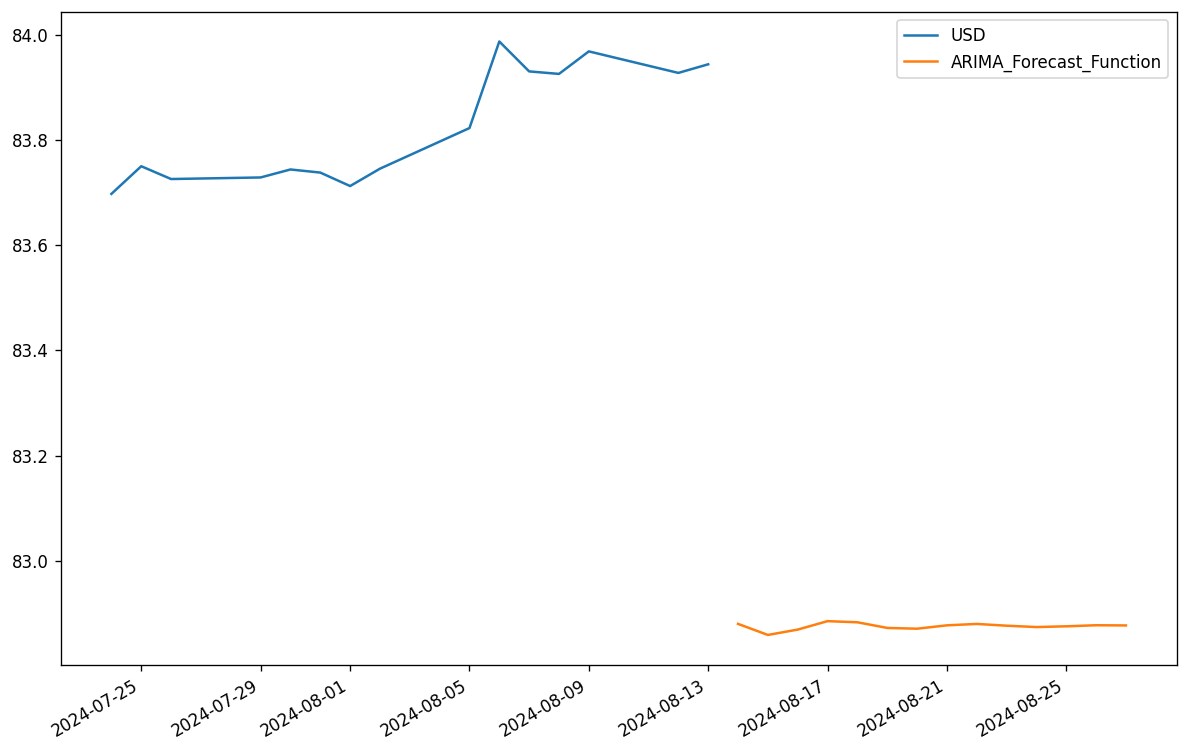

In [46]:
forecast[[name,'ARIMA_Forecast_Function']][len(data) - 15:].plot(figsize = (12,8))

<Axes: >

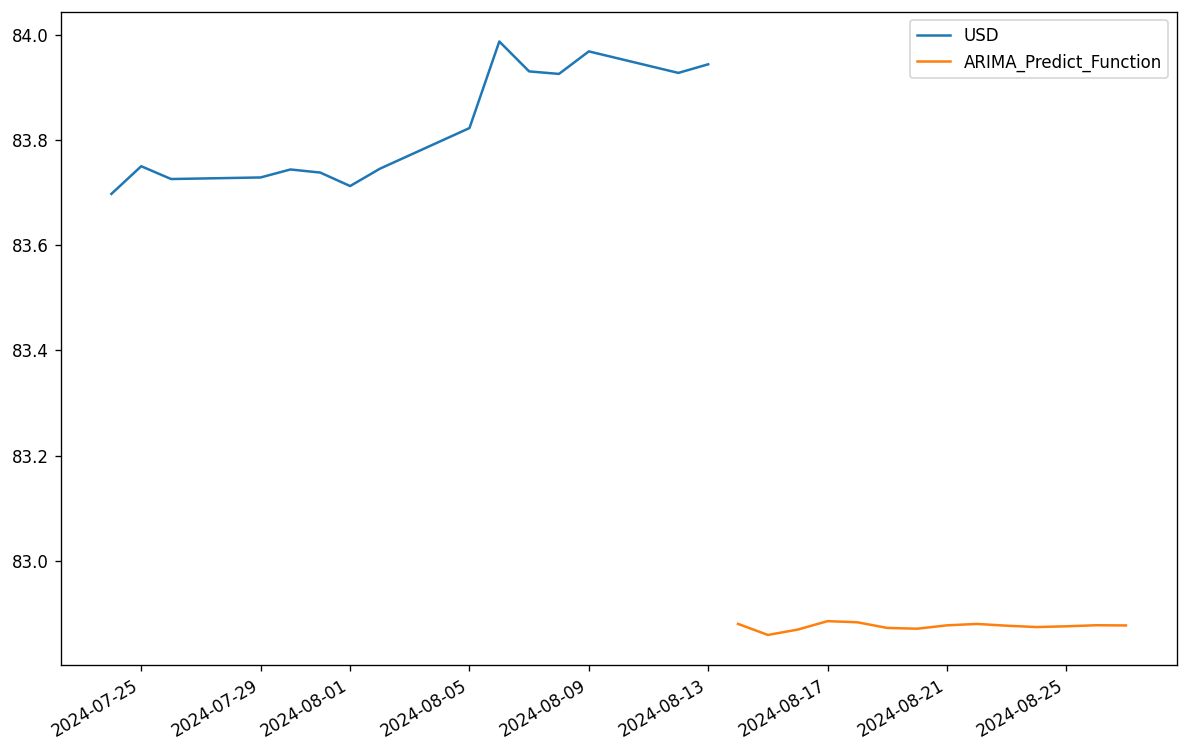

In [47]:
forecast[[name,'ARIMA_Predict_Function']][len(data) - 15:].plot(figsize = (12,8))

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = df.copy()

for col in df.columns:
    df_norm[col] = scaler.fit_transform(df_norm[col].values.reshape(-1,1))

df_norm.tail()


,USD
DATE,
2024-08-07,0.998735
2024-08-08,0.998628
2024-08-09,0.999581
2024-08-12,0.998671
2024-08-13,0.999035


In [49]:
data = pd.DataFrame(df_norm[name])
data

,USD
DATE,
2000-01-03,0.097079
2000-01-04,0.098081
2000-01-05,0.098304
2000-01-06,0.098304
2000-01-07,0.098192
...,...
2024-08-07,0.998735
2024-08-08,0.998628
2024-08-09,0.999581


In [50]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    data = np.array(data)
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [51]:
seq_length = 15
x, y = sliding_windows(data, seq_length)
print(x.shape)
print(y.shape)

(6403, 15, 1)
(6403, 1)


In [52]:
#train_size = int(len(y) * 0.67)
#test_size = len(y) - train_size

train_size = int(len(df) - seq_length*0.3)
test_size =  len(df) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [53]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([6403, 15, 1])
train label shape is: torch.Size([6403, 1])
test shape is: torch.Size([0, 15, 1])
test label shape is: torch.Size([0, 1])


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.dropout(out)

        return out

In [56]:
num_epochs = 50
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

In [57]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.to(device)

criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [58]:
for epoch in progress_bar(range(num_epochs)):
    model.train()
    outputs = model(trainX.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))

    loss.backward()

    scheduler.step(loss)
    optimizer.step()
    model.eval()
    with torch.no_grad():
        valid = model(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))
        scheduler.step(vall_loss)
        torch.cuda.empty_cache()

    if (epoch) % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.27218 valid loss:  nan 


In [59]:
model.eval()
with torch.no_grad():
    train_predict = model(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()

    data_predict = scaler.inverse_transform(data_predict)
    dataY_plot = scaler.inverse_transform(dataY_plot)

    df_predict = pd.DataFrame(data_predict)
    df_labels = pd.DataFrame(dataY_plot)
    torch.cuda.empty_cache()

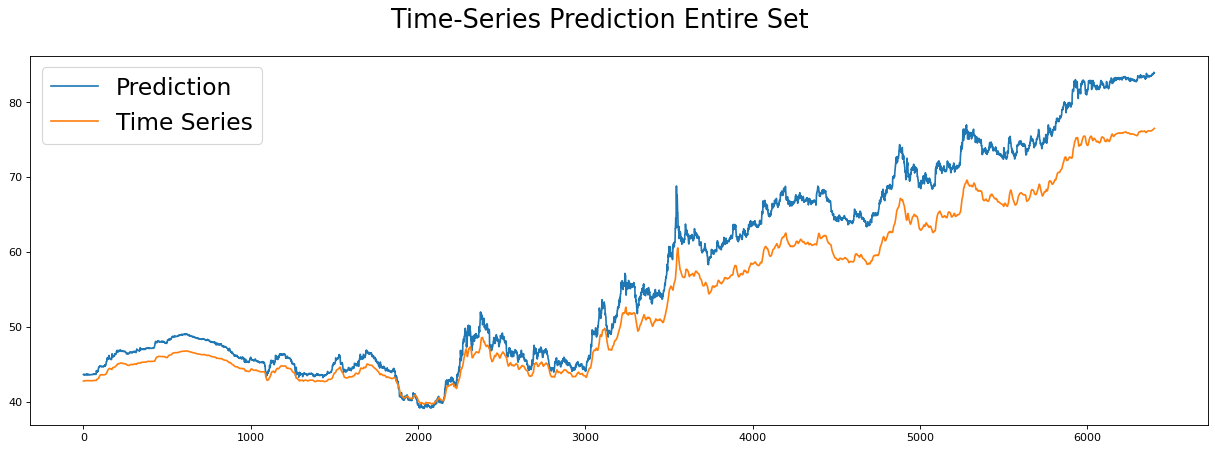

In [60]:
plt.figure(num=None, figsize=(19, 6), dpi=80)
plt.plot(df_labels[0])
plt.plot(df_predict[0])
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.show()

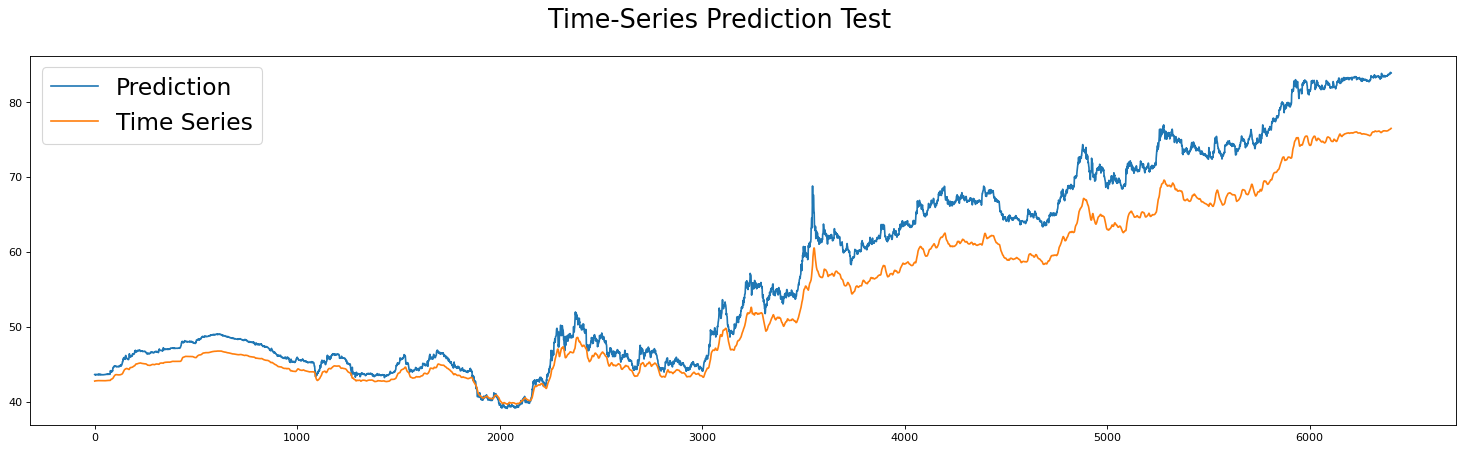

In [61]:
plt.figure(num=None, figsize=(23, 6), dpi=80)
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.show()

In [62]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

4.429694

In [63]:
train_data = torch.FloatTensor(x).unsqueeze(1).to(device)
test_data = torch.FloatTensor(y).unsqueeze(1).to(device)

In [64]:
num_predictions = 15

model.eval()
inputs = torch.tensor(test_data[-input_size:].reshape(1, input_size, 1), dtype=torch.float32).to(device)

predictions1 = []
with torch.no_grad():
    for i in range(num_predictions):
        # Forward pass
        outputs = model(inputs.to(device))

        # Save the prediction
        predictions1.append(outputs.item())

        # Update the input sequence for the next time step
        inputs = torch.cat((inputs[:, 1:, :], outputs.reshape(1, 1, 1)), axis=1)

        torch.cuda.empty_cache()

# Print the predicted sequence
print('Predicted Sequence:', predictions1)

Predicted Sequence: [0.09668656438589096, 0.03260750323534012, 0.028116052970290184, 0.02780156023800373, 0.02777954377233982, 0.027778001502156258, 0.027777889743447304, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005, 0.027777886018157005]


In [65]:
def rev_min_max_func(scaled_val):
    max_val = max(df[name])
    min_val = min(df[name])
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val

pred1 = pd.Series(predictions1).apply(lambda x: rev_min_max_func(x))
pred1

,0
0,43.417370
1,40.539462
2,40.337743
3,40.323619
4,40.322630
5,40.322561
6,40.322556
7,40.322555
8,40.322555
9,40.322555


In [66]:
forecast['Single LSTM'] = np.NaN

for i in range(len(pred1)):
    forecast.loc[len(data) - i,'Single LSTM'] = pred1[i]
forecast.tail(20)
#pred1

,USD,diff,ARIMA_Forecast_Function,ARIMA_Predict_Function,Single LSTM
2024-08-23 00:00:00,NaN,NaN,82.876641,82.876641,NaN
2024-08-24 00:00:00,NaN,NaN,82.874060,82.874060,NaN
2024-08-25 00:00:00,NaN,NaN,82.875491,82.875491,NaN
2024-08-26 00:00:00,NaN,NaN,82.877509,82.877509,NaN
2024-08-27 00:00:00,NaN,NaN,82.877141,82.877141,NaN
6419,NaN,NaN,NaN,NaN,43.417370
6418,NaN,NaN,NaN,NaN,40.539462
6417,NaN,NaN,NaN,NaN,40.337743
6416,NaN,NaN,NaN,NaN,40.323619
6415,NaN,NaN,NaN,NaN,40.322630


In [67]:
torch.cuda.empty_cache()

In [68]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.batch_size = 1
        #self.seq_length = seq_length

        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)

        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))

        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)

        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [69]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [70]:
num_epochs = 50
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2
num_classes = 1

In [71]:
lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [72]:
for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))

    loss.backward()

    scheduler.step(loss)
    optimizer.step()
    lstm.eval()

    with torch.no_grad():
        valid = lstm(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))
        scheduler.step(vall_loss)
        torch.cuda.empty_cache()

    if (epoch) % 50 == 0:
        print("Epoch: %d, Train Loss: %1.5f, Valid Loss: %1.5f" %(epoch, loss, vall_loss))

Epoch: 0, Train Loss: 0.31411, Valid Loss: nan


In [73]:
lstm.eval()
with torch.no_grad():
    train_predict = lstm(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()

    data_predict = scaler.inverse_transform(data_predict)
    dataY_plot = scaler.inverse_transform(dataY_plot)

    df_predict = pd.DataFrame(data_predict)
    df_labels = pd.DataFrame(dataY_plot)

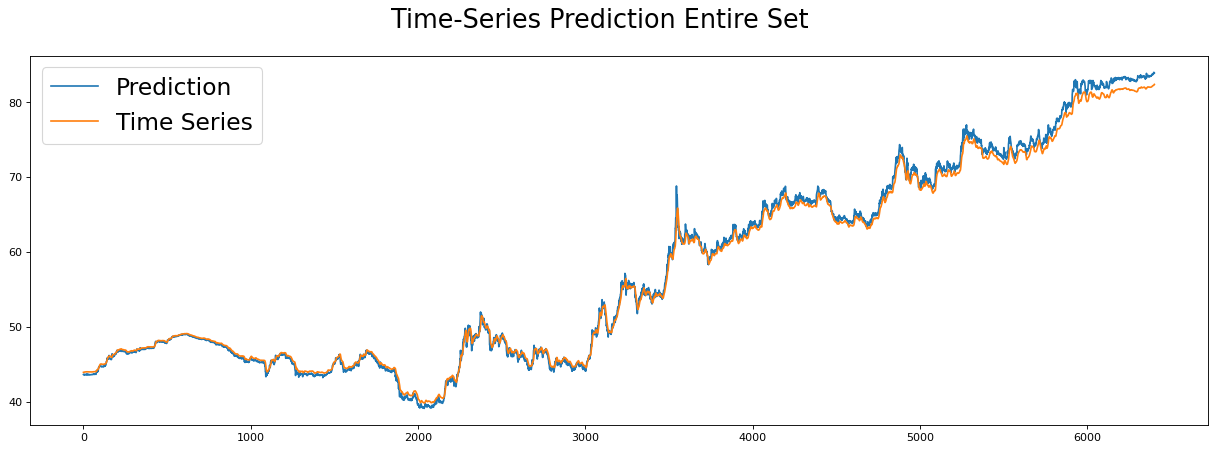

In [74]:
plt.figure(num=None, figsize=(19, 6), dpi=80)
plt.plot(df_labels[0])
plt.plot(df_predict[0])
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.show()

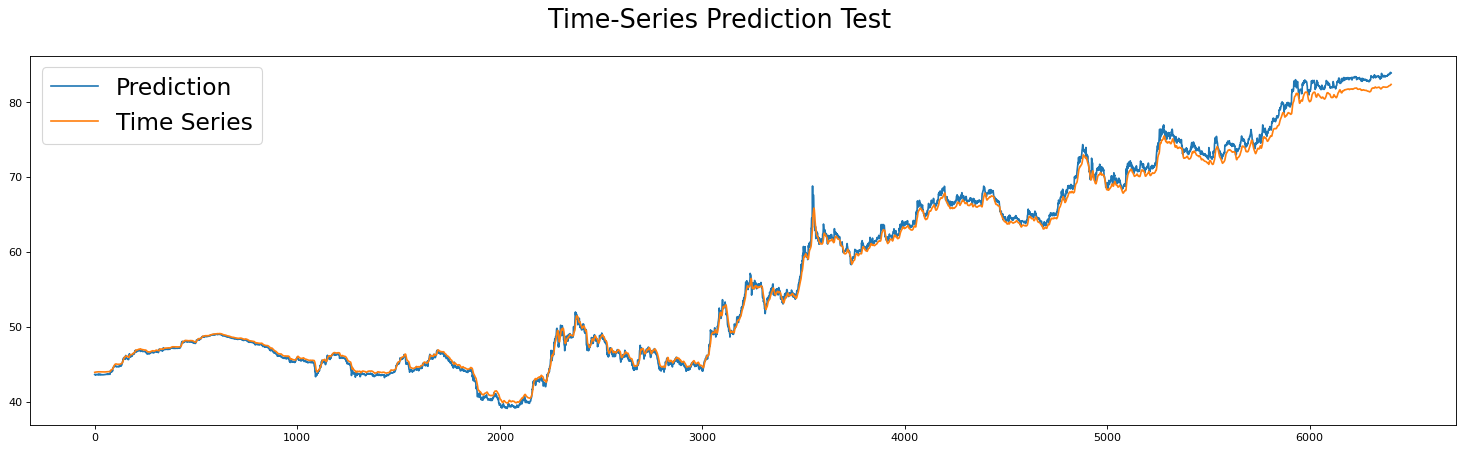

In [75]:
plt.figure(num=None, figsize=(23, 6), dpi=80)
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.show()

In [76]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.74942446

In [77]:
num_predictions = 15

lstm.eval()
inputs = torch.tensor(test_data[-input_size:].reshape(1, input_size, 1), dtype=torch.float32).to(device)

predictions2 = []
with torch.no_grad():
    for i in range(num_predictions):
        # Forward pass
        outputs = lstm(inputs.to(device))

        # Save the prediction
        predictions2.append(outputs.item())

        # Update the input sequence for the next time step
        inputs = torch.cat((inputs[:, 1:, :], outputs.reshape(1, 1, 1)), axis=1)

        torch.cuda.empty_cache()

# Print the predicted sequence
print('Predicted Sequence:', predictions2)

Predicted Sequence: [0.1557992547750473, 0.0634469985961914, 0.05337115749716759, 0.05227263644337654, 0.05215287581086159, 0.05213982239365578, 0.05213839188218117, 0.05213824287056923, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035]


In [78]:
num_predictions = 15

lstm.eval()
inputs = torch.tensor(test_data[-input_size:].reshape(1, input_size, 1), dtype=torch.float32).to(device)

predictions2 = []
with torch.no_grad():
    for i in range(num_predictions):
        # Forward pass
        outputs = lstm(inputs.to(device))

        # Save the prediction
        predictions2.append(outputs.item())

        # Update the input sequence for the next time step
        inputs = torch.cat((inputs[:, 1:, :], outputs.reshape(1, 1, 1)), axis=1)

        torch.cuda.empty_cache()

# Print the predicted sequence
print('Predicted Sequence:', predictions2)

Predicted Sequence: [0.1557992547750473, 0.0634469985961914, 0.05337115749716759, 0.05227263644337654, 0.05215287581086159, 0.05213982239365578, 0.05213839188218117, 0.05213824287056923, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035, 0.05213822051882744, 0.052138227969408035]


In [79]:
def rev_min_max_func(scaled_val):
    max_val = max(df[name])
    min_val = min(df[name])
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val

pred2 = pd.Series(predictions2).apply(lambda x: rev_min_max_func(x))
pred2

,0
0,46.072228
1,41.924520
2,41.471996
3,41.422659
4,41.417281
5,41.416694
6,41.416630
7,41.416623
8,41.416623
9,41.416622


In [81]:
forecast['Multiple LSTM'] = np.NaN

for i in range(len(pred2)):
    forecast.loc[len(data) - i,'Multiple LSTM'] = pred2[i]
forecast.tail(30)

,USD,diff,ARIMA_Forecast_Function,ARIMA_Predict_Function,Single LSTM,Multiple LSTM
2024-08-13 00:00:00,83.9435,0.01638,NaN,NaN,NaN,NaN
2024-08-14 00:00:00,NaN,NaN,82.880102,82.880102,NaN,NaN
2024-08-15 00:00:00,NaN,NaN,82.859065,82.859065,NaN,NaN
2024-08-16 00:00:00,NaN,NaN,82.869243,82.869243,NaN,NaN
2024-08-17 00:00:00,NaN,NaN,82.885285,82.885285,NaN,NaN
2024-08-18 00:00:00,NaN,NaN,82.883135,82.883135,NaN,NaN
2024-08-19 00:00:00,NaN,NaN,82.872408,82.872408,NaN,NaN
2024-08-20 00:00:00,NaN,NaN,82.870923,82.870923,NaN,NaN
2024-08-21 00:00:00,NaN,NaN,82.877323,82.877323,NaN,NaN
2024-08-22 00:00:00,NaN,NaN,82.879986,82.879986,NaN,NaN
